In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [32]:
len(words)

32033

In [33]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [34]:
# build the dataset
block_size = 3  # how many characters to predict

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # append the context
            Y.append(ix) # append the next character
            context = context[1:] + [ix] # crop and append the new character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # shuffle the words to get a good mix
n1 = int(0.8 * len(words))  # 80% for training
n2 = int(0.9 * len(words)) # 10% for validation

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Calculating the initial scale using Kaiming initialization - gain/sqrt(fan_in)

gain  = 5/3 for tanh, sqrt(2) for relu

fan_in = n_embd * block_size  # number of input units (30)

(5/3) / (fan_in ** 0.5)

In [35]:
# MLP revisited
n_embd = 10  # embedding dimension
n_hidden = 200  # no. of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd)                    , generator=g)                                # embedding matrix
fan_in = n_embd * block_size                                                                          # number of input units
W1 = torch.randn((fan_in, n_hidden)        , generator=g) * ((5/3) / (fan_in ** 0.5))                 # weights initialized to small values to avoid bias in the initial loss
#b1 = torch.randn(n_hidden                               , generator=g) * 0.01                        # bias initialized to small values to avoid bias in the initial loss
W2 = torch.randn((n_hidden, vocab_size)                 , generator=g) * 0.01                         # weights initialized to small values because we want to avoid bias in the initial loss
b2 = torch.randn(vocab_size                             , generator=g) * 0                            # bias initialized to zero becasue we want to avoid bias in the initial loss

bngain = torch.ones(1, n_hidden)  # batch normalization gain
bnbias = torch.zeros(1, n_hidden)  # batch normalization bias
bnmean_running = torch.zeros(1, n_hidden)  # batch normalization running mean on the side of the model training
bnstd_running = torch.ones(1, n_hidden)  # batch normalization running standard deviation on the side of the model training
 
parameters = [C, W1, W2, b2, bngain, bnbias]  # list of all parameters
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True  # enable gradient computation

Number of parameters: 12097


In [36]:
# same optimization loop as before
max_steps = 200000
batch_size = 32
lossi = []

for _ in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)  # random indices for the mini-batch
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass
    emb = C[Xb]  # embedding lookup
    embcat = emb.view(emb.shape[0], -1)  # flatten the embedding / concatenate the vectors
    # linear layer
    hpreact = embcat @ W1 #+ b1  # hidden layer pre-activation
    # Batch norm layer - newer and better normalization techniques include group normalization and layer normalization 
    #-------------------------------------------------------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)  # mean over the batch dimension at i-th iteration
    bnstdi = hpreact.std(0, keepdim=True)  # standard deviation over the batch dimension at i-th iteration
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias # take every single neuron and its exact firing rate will be exaclty unit gaussian
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running    + 0.001 * bnmeani # update the running mean (0.999 is the momentumm, 0.001 is the learning rate, bnmeani is the current mean)
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # update the running standard deviation - while the network is learning, the running standard deviation will get closer to the actual standard deviation
    #-------------------------------------------------------------------------------------------------------------------------------------

    # Non - linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # compute loss

    # backward pass
    for p in parameters:
        p.grad = None  # zero out gradients
    loss.backward()  # compute gradients

    # update the parameters
    lr = 0.1 if _ < 100000 else 0.01  # fixed learning rate using track status first 0.1 for first 100000 iterations, then 0.01(learning rate decay)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if _ % 10000 == 0:
        print(f'{_:7d}/{max_steps:7d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break

      0/ 200000 loss: 3.3239
  10000/ 200000 loss: 2.0322
  20000/ 200000 loss: 2.5675
  30000/ 200000 loss: 2.0125
  40000/ 200000 loss: 2.2446
  50000/ 200000 loss: 1.8897
  60000/ 200000 loss: 2.0785
  70000/ 200000 loss: 2.3681
  80000/ 200000 loss: 2.2918
  90000/ 200000 loss: 2.0238
 100000/ 200000 loss: 2.3673
 110000/ 200000 loss: 2.3132
 120000/ 200000 loss: 1.6414
 130000/ 200000 loss: 1.9311
 140000/ 200000 loss: 2.2231
 150000/ 200000 loss: 2.0027
 160000/ 200000 loss: 2.0997
 170000/ 200000 loss: 2.4949
 180000/ 200000 loss: 2.0199
 190000/ 200000 loss: 2.1707


In [37]:
hpreact.shape

torch.Size([32, 200])

In [38]:
hpreact.mean(0, keepdim=True).shape # mean over the batch dimension. 

torch.Size([1, 200])

In [39]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

Text(0, 0.5, 'Input characters')

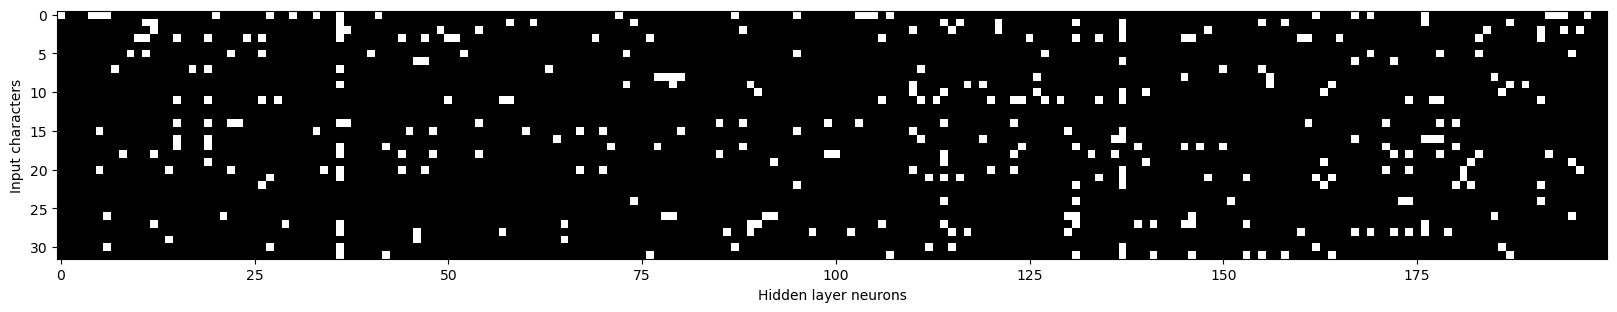

In [40]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest') # boolean tensor  - white for high absolute values, black for low (if a whole column is white => the neuron is active for all characters/ or a dead neuron)
plt.xlabel('Hidden layer neurons')
plt.ylabel('Input characters')
# dead neurons are neurons that are not active for any character, i.e. they have zero activation for all characters

# Ideal inital loss

(array([473., 236., 208., 155., 141., 128., 108., 102.,  98., 109.,  78.,
         93., 106.,  85.,  86., 112., 119., 120., 109., 103., 112., 103.,
        112.,  86., 100., 126.,  96.,  78., 118.,  91.,  84., 109., 107.,
         88., 104.,  87.,  81.,  78., 107.,  88., 103., 106.,  80., 128.,
        141., 114., 137., 184., 232., 451.]),
 array([-9.99970257e-01, -9.59970877e-01, -9.19971497e-01, -8.79972117e-01,
        -8.39972737e-01, -7.99973357e-01, -7.59973977e-01, -7.19974597e-01,
        -6.79975216e-01, -6.39975836e-01, -5.99976456e-01, -5.59977076e-01,
        -5.19977696e-01, -4.79978316e-01, -4.39978936e-01, -3.99979556e-01,
        -3.59980175e-01, -3.19980795e-01, -2.79981415e-01, -2.39982035e-01,
        -1.99982655e-01, -1.59983275e-01, -1.19983895e-01, -7.99845147e-02,
        -3.99851346e-02,  1.42455101e-05,  4.00136256e-02,  8.00130057e-02,
         1.20012386e-01,  1.60011766e-01,  2.00011146e-01,  2.40010526e-01,
         2.80009906e-01,  3.20009286e-01,  3.60008

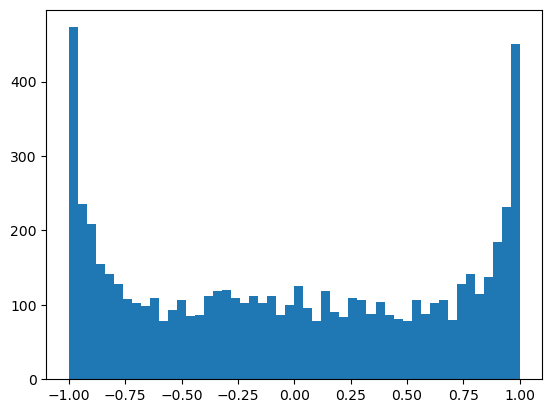

In [41]:
plt.hist(h.view(-1).tolist(), 50) 

(array([  1.,   1.,   2.,   2.,   1.,   7.,  13.,  17.,  27.,  32.,  56.,
         72.,  98., 115., 150., 209., 244., 301., 350., 407., 613., 660.,
        603., 499., 396., 340., 253., 217., 176., 140., 126.,  86.,  67.,
         39.,  24.,  21.,   9.,   6.,   6.,   2.,   5.,   1.,   1.,   1.,
          0.,   2.,   0.,   1.,   0.,   1.]),
 array([-5.55809402, -5.3040221 , -5.04995018, -4.79587826, -4.54180634,
        -4.28773441, -4.03366249, -3.77959057, -3.52551865, -3.27144672,
        -3.0173748 , -2.76330288, -2.50923096, -2.25515903, -2.00108711,
        -1.74701519, -1.49294327, -1.23887135, -0.98479942, -0.7307275 ,
        -0.47665558, -0.22258366,  0.03148827,  0.28556019,  0.53963211,
         0.79370403,  1.04777596,  1.30184788,  1.5559198 ,  1.80999172,
         2.06406364,  2.31813557,  2.57220749,  2.82627941,  3.08035133,
         3.33442326,  3.58849518,  3.8425671 ,  4.09663902,  4.35071095,
         4.60478287,  4.85885479,  5.11292671,  5.36699863,  5.62107056,
 

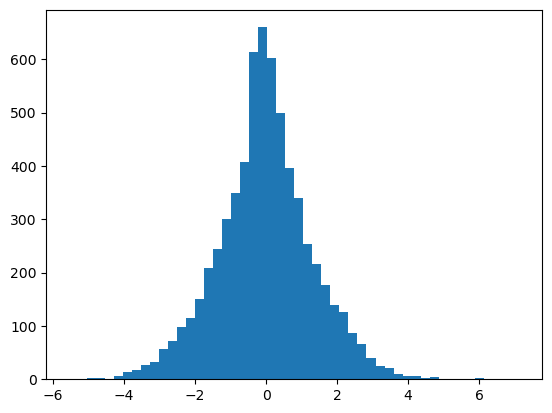

In [42]:
plt.hist(hpreact.view(-1).tolist(), 50) 

In [43]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [44]:
# 4 dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])  # logits for 4 classes have to be equal to avoid bias and high loss
probs = torch.softmax(logits, dim=0)  # compute probabilities
loss = -probs[2].log().mean()  # compute loss
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

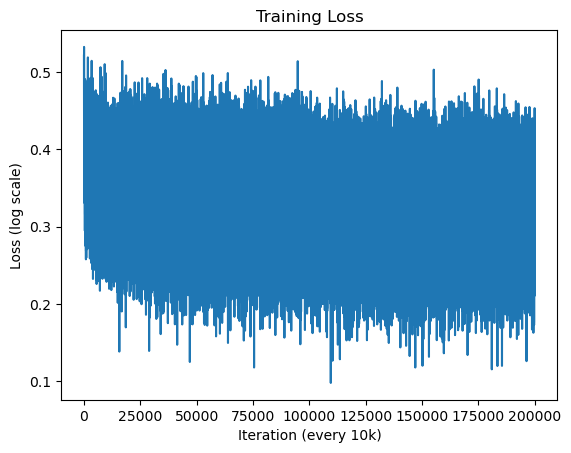

In [45]:
plt.plot(lossi)
plt.xlabel('Iteration (every 10k)')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss')
plt.show()

In [46]:
# Calibrate the batch norm at the end of the training - 
# this calculates and sets the batch mean and standard deviation a single timeover the training set

with torch.no_grad():
    # pass the training set through
    emb = C[Xtrain]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # get the preactivation for every example
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [47]:
@torch.no_grad() # decorator disable gradient computation for evaluation
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    } [split] # get the data for the split
    emb = C[x] # embedding lookup - (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True) + 1e-5) + bnbias # take every single neuron and its exact firing rate will be exaclty unit gaussian
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias # take every single neuron and its exact firing rate will be exaclty unit gaussian
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # output layer (N, vocab_size)
    loss = F.cross_entropy(logits, y) # compute loss
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.0674
val loss: 2.1057


# loss log

# original:
train 2.1245384216308594

val 2.168196439743042

# fix softmax confidently wrong:
train 2.07

val 2.13

# fix tanh layer too saturated at init:
train 2.0355966091156006

val 2.1026785373687744

# use semi-principled "kaiming init" instead of hacky init
train 2.0376641750335693

val 2.168196439743042

# add a batch norm layer
train 2.0668270587921143 

val 2.104844808578491


It is customary to sprinkle batch normalization layers throughout the neural net right after linear pre-activation layers to control the scale of these activations.

This also results in data augmentaion of h and logits by making them jitter to augment the input, kind of a regularization effect- basically a good thing as a secondary side effect which stabilizes the training.

In [48]:
# sample from the model
g= torch.Generator().manual_seed(2147483647)  # for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size  # start with a context of zeros
    while True:
        emb = C[torch.tensor([context])]  # get the embedding for the context
        h = torch.tanh(emb.view(1, -1) @ W1 )  #+ b1  # hidden layer
        logits = h @ W2 + b2  # output layer
        probs = F.softmax(logits, dim=1)  # convert to probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # sample from the distribution
        if ix == 0: break  # stop if we hit the end token
        out.append(itos[ix])  # append the character to the output
        context = context[1:] + [ix]  # update the context

    print(''.join(out))  # print the generated name

junidhk
pragid
prrsty
blnnikottr
toldda
stel
bdassiausiagreviasshbdainrwistadssisselysabreziahmunthyfferriff
ffisziahritzl
soffayrenocklyssabdulehz
bissaydin
thaaslusslimassuxhsdgotfmitta
klustlyanamthstze
sreli
khamdys
sumeksocklavubishbphm
samarriyahhmaritta
pplynabtly
quinzammritzlyhamirahawna
ffindly
favisstoksmiahaell


# Summary

In [110]:
# let's train a deeper network
# we can use the same model, but with more hidden layers

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1): # momentum is to keep track of the running mean and variance
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
            with torch.no_grad():  # update the running mean and variance using context manager to prevent gradient computation 
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    def __init__(self):
        self.out = None
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
        
n_embd = 10  # embedding dimension
n_hidden = 100  # number of hidden neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

#C = torch.randn((vocab_size, n_embd),                       generator=g)  # embedding matrix
#layers = [
#    Linear(n_embd * block_size, n_hidden), Tanh(),                        # first layer  - input layer      
#    Linear(           n_hidden, n_hidden), Tanh(),
#    Linear(           n_hidden, n_hidden), Tanh(),                        # layers that are stacked together into a list
#    Linear(           n_hidden, n_hidden), Tanh(),
#    Linear(           n_hidden, n_hidden), Tanh(),
#    Linear(           n_hidden, vocab_size), 
#]

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                        # first layer  - input layer      
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                        # layers that are stacked together into a list
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: makes less confident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # to make last layer softmax less confident, we'd be changing the gamma because, gamma is the parameter that multiplicatively interacts with the output. see below markdown
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0  #5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True  # enable gradient computation

47024


When you’re using BatchNorm after the final Linear, the magnitude of the logits is controlled by gamma, not the linear weights.
So to reduce overconfidence of softmax, you must scale down gamma, not W2, because:
logits = BatchNorm1d(Linear(h))  
        = γ * ((h @ W2 + b2 - μ) / √(σ² + ε)) + β

In [111]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_data_ratio = []

for _ in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate into a single vector per example
    for layer in layers:
        x= layer(x)
    loss = F.cross_entropy(x, Yb)  # compute the loss

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph (iterate over every layer and retain the gradient of the output of each layer)
    for p in parameters:
        p.grad = None  # zero out gradients
    loss.backward()  # compute gradients

    # update the parameters
    lr = 0.1 if _ < 150000 else 0.01  # fixed learning rate using track status first 0.1 for first 100000 iterations, then 0.01(learning rate decay)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if _ % 10000 == 0:
        print(f'{_:7d}/{max_steps:7d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        update_data_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if _ >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000 loss: 3.3334


layer 2 (      Tanh): mean = -0.01, std = +0.64, saturated: 2.16%
layer 5 (      Tanh): mean = -0.00, std = +0.64, saturated: 2.59%
layer 8 (      Tanh): mean = -0.00, std = +0.65, saturated: 1.91%
layer 11 (      Tanh): mean = +0.01, std = +0.65, saturated: 1.53%
layer 14 (      Tanh): mean = -0.00, std = +0.66, saturated: 1.28%


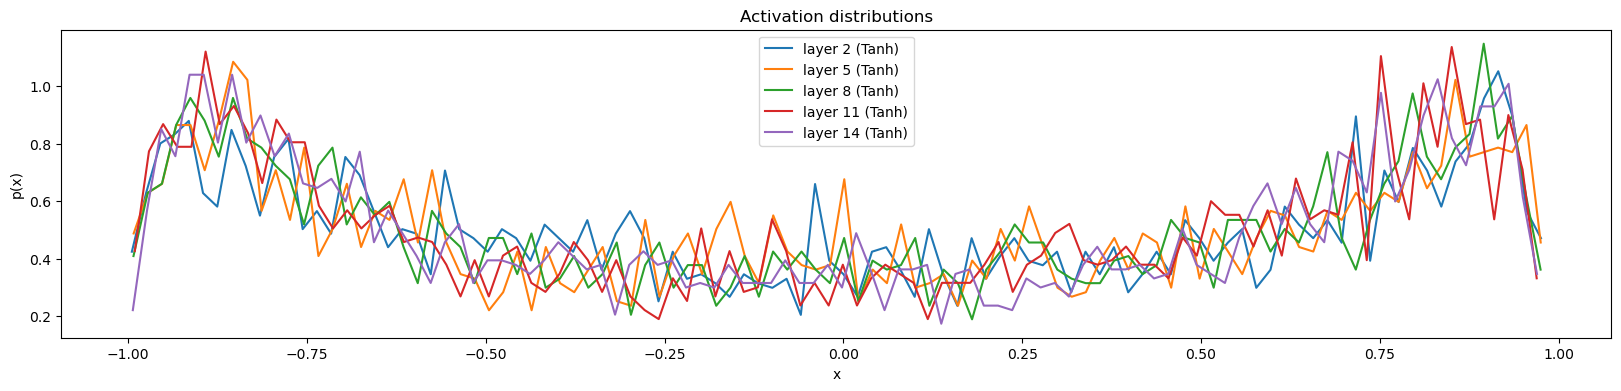

In [112]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: we don't plot the last(output) layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean = %+.2f, std = %+.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() >  0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distributions')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()


layer 2 (      Tanh): mean -0.000000, std 2.095567e-03
layer 5 (      Tanh): mean +0.000000, std 1.783101e-03
layer 8 (      Tanh): mean -0.000000, std 1.671655e-03
layer 11 (      Tanh): mean +0.000000, std 1.640275e-03
layer 14 (      Tanh): mean +0.000000, std 1.800997e-03


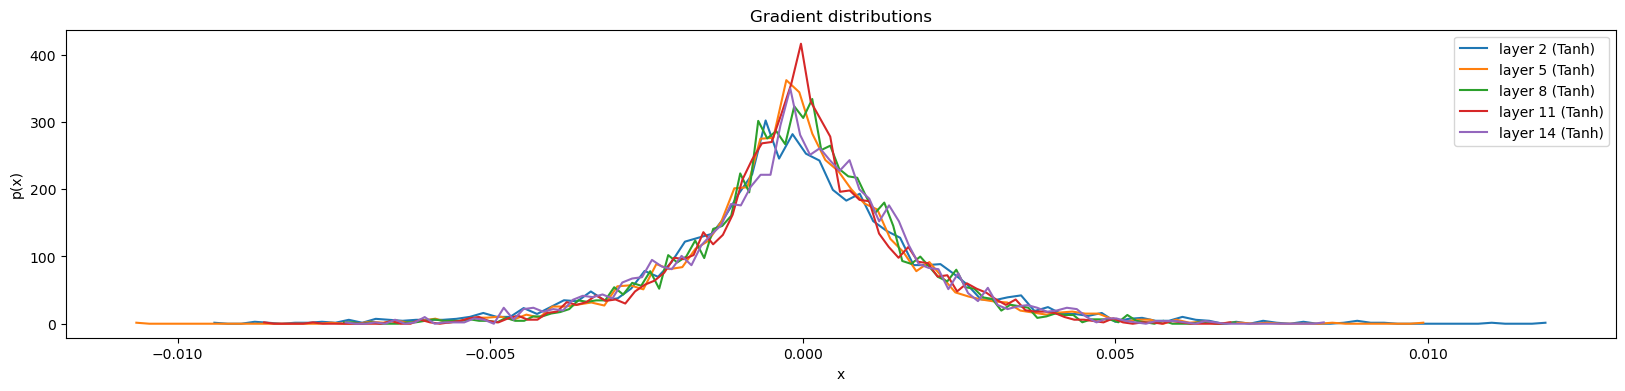

In [113]:
# visualize histogram for gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: we don't plot the last(output) layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distributions')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

weight   (27, 10)  |  mean -0.000000  |  std 7.260283e-03  |  grad:data ratio 7.248895e-03
weight  (30, 100)  |  mean +0.000235  |  std 8.622179e-03  |  grad:data ratio 4.615001e-02
weight (100, 100)  |  mean -0.000088  |  std 6.336941e-03  |  grad:data ratio 6.170982e-02
weight (100, 100)  |  mean -0.000107  |  std 5.598838e-03  |  grad:data ratio 5.499918e-02
weight (100, 100)  |  mean -0.000108  |  std 5.150731e-03  |  grad:data ratio 5.065437e-02
weight (100, 100)  |  mean -0.000031  |  std 5.128507e-03  |  grad:data ratio 5.018060e-02
weight  (100, 27)  |  mean +0.000044  |  std 1.141915e-02  |  grad:data ratio 1.095914e-01


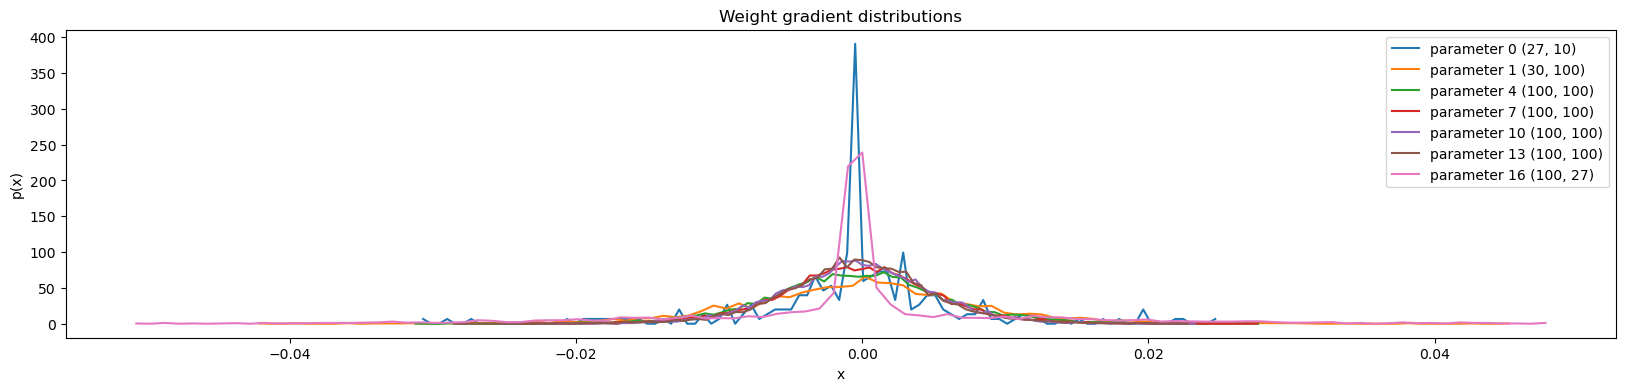

In [114]:
# visualize histograms for weight gradient distribution
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s  |  mean %+f  |  std %e  |  grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'parameter {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weight gradient distributions')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

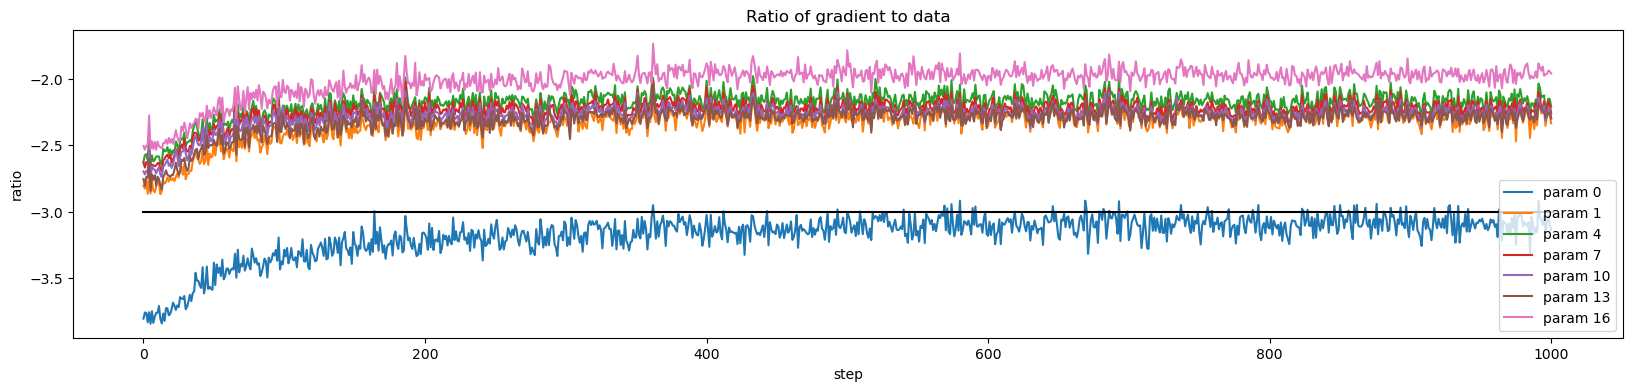

In [115]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_data_ratio[j][i] for j in range(len(update_data_ratio))])
        legends.append('param %d' % i)
plt.plot([0, len(update_data_ratio)], [-3, -3], 'k') # these ratios should be less than ~1e-3, indicating that gradients are close to data
plt.legend(legends)
plt.title('Ratio of gradient to data')
plt.xlabel('step')
plt.ylabel('ratio')
plt.show()